# Spectogram Dataset

## Dataset

Here we create the dataset

In [27]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


class GTZANSpectogramDataset(Dataset):
    def __init__(self, features_file, img_dir, transform=None, target_transform=None):
        """
        Args:
            features_file (string): Path to the csv file with features.
            img_dir (string): Directory with all the spectrogram images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        # We drop the feature related to the length of the audio file
        self.features_frame = pd.read_csv(features_file).drop('length', axis=1)         
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.features_frame)


    def __getitem__(self, idx):
        # Load image data
        while True:
            try:
                img_name = self.generate_gtzan_full_img_name(self.features_frame.iloc[idx, 0], self.img_dir)
                image_rgba = Image.open(img_name)
                break
            except:
                # We skip the image that we can't open
                #print(f"Error opening image {img_name}")  # 'jazz.00054.png' is missing
                idx += 1
        image = image_rgba.convert("L")    # We convert the img to greyscale

        # Load label
        label = self.features_frame.iloc[idx, -1]


        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label


    def generate_gtzan_full_img_name(self, original_img_name, img_dir):
        """ 
            The file name in the csv is 'reggae.00019.wav', 
            we neet to change it to '\\reggae\\reggae00019.png'
        """
        # We have to change the extension of the file
        img_file_name = original_img_name.replace('.wav', '.png')
        # To get the name of the folder we need to remove '.png' and the identifiers numbers (ex '.00000)'
        img_folder_name = img_file_name[:-10]    
        # Now we need to remove the '.' between 'reggae.00019'    
        img_file_name = img_file_name[:-10] + img_file_name[-9:]    
        # Now we can create the full path   
        img_name = os.path.join(img_dir, img_folder_name, img_file_name)

        return img_name

In [28]:
# Path to the csv file with the features
features_file = 'Data\\features_30_sec.csv'
img_dir = 'Data\\images_original'

### Custom Transformations for the dataset


Here we create some custom trasnformation for our dataset


This trasformation encodes the labels in a one hot vector


In [29]:
class LabelTransform:
    def __init__(self, label_set):
        # Map each of the first 10 letters of the alphabet to an index
        self.label_to_index = {label: index for index, label in enumerate(label_set)}

    def __call__(self, label):
        # Initialize a one-hot encoded tensor of size 10 (for 10 classes)
        one_hot = torch.zeros(10, dtype=torch.float)
        # Set the appropriate position to 1 based on the label index
        label_index = self.label_to_index[label]
        one_hot[label_index] = 1.0
        # return one_hot
        return self.label_to_index[label]


labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock']
# Example usage of the transform
label_transform = LabelTransform(labels)

Here we instantiate the actual transformations


In [30]:
# Example usage of the transform
label_transform = LabelTransform(labels)


# This transform also normalizes
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.466],            
                         std=[0.459])
])

Here we are creating the training and test dataset


In [31]:
# Create the dataset
gtzan_dataset = GTZANSpectogramDataset(features_file=features_file, img_dir=img_dir, transform=transform_norm, target_transform=label_transform)
# Split the dataset into training and test sets
training_data, test_data = torch.utils.data.random_split(gtzan_dataset, [800, 200])

# Create data loaders
batch_size = 50
shuffle = True
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=shuffle)         # Each element in the dataloader iterable will return a batch of 64 features and labels.
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=shuffle) 

## Creating the Model


To build this model we used the official pytorch tutorials


 Code for convolutional NN

Let's calculate the size of the output from the last convolutional block before it is flattened and fed into the fully connected layer.

Initial Size: 432x288
- After 1st Pooling: Since the pooling operation halves the dimensions, after the first convolutional block, the size will be 216x144.
- After 2nd Pooling: Halving again, the size becomes 108x72.
- After 3rd Pooling: Further reduced to 54x36.
- After 4th Pooling: Becomes 27x18.
- After 5th Pooling: Finally, reduced to 13x9.          (we removed this block to simplufy the model)
The output feature map size just before the fully connected layer will be 13x9x256 = 29.952    (27x18x128 = 62208)


In [32]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


# Define model
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Input layer is defined implicitly by the input size of the first convolutional layer
        
        # Convolutional blocks
        self.conv_layers = nn.Sequential(
            # Block 1: Conv -> ReLU -> MaxPool -> Dropout
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            
            # Block 2: Conv -> ReLU -> MaxPool -> Dropout
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            
            # Block 3: Conv -> ReLU -> MaxPool -> Dropout
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            
            # Block 4: Conv -> ReLU -> MaxPool -> Dropout
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),

            # # Block 5: Conv -> ReLU -> MaxPool -> Dropout
            # nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(0.2),
            
        )
        
       # Flatten the otput of the convolution block and add one hidden layer of 64 neurons
        self.fc2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(62208, 64),           #nn.Linear(29952, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        # x = self.fc_dropout(x)
        logits = self.fc2(x)
        return logits
    

# Our model
model = ConvNet().to(device)
print(model)

Using cpu device
ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.2, inplace=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.2, inplace=False)
  )
  (fc2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_featu

## Training the model


Here we choose the optimizers


In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Training loop: the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.  (code from the official pytorch tutorials)

In [34]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    # Sets the model in 'training' mode
    model.train()                                        #  This helps inform layers such as Dropout and BatchNorm, which are
                                                         #   designed to behave differently during training and evaluation.
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)               # '.to(device)' allows you to move the data to the device you are using (ex. GPU memory)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()                            # This command resets the gradients (pytorch acumulates them by default)


    print(f"loss: {loss:>7f}")
    return loss.item()            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model's performance against the test dataset to ensure it is learning.


In [35]:
def test_loss(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)                   # c'e' un problema, il batch è 10!!!

    # Sets the model in 'evaluation' mode
    model.eval()

    test_loss = 0

    # Temporarily disable gradients computation
    with torch.no_grad():                                 # This disables the memorization of the activation functions during the forward pass
        for X, y in dataloader:                           #  (they are used in the backprop phase to compute the gradients)
            X, y = X.to(device), y.to(device)     
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss

In [36]:
def test_accuracy(dataloader, model):
    size = len(dataloader.dataset)


    # Sets the model in 'evaluation' mode
    model.eval()

    correct = 0

    # Temporarily disable gradients computation
    with torch.no_grad():                                 # This disables the memorization of the activation functions during the forward pass
        for X, y in dataloader:                           #  (they are used in the backprop phase to compute the gradients)
            X, y = X.to(device), y.to(device)     
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()     # The prediction is the argmax of the last layer
    correct /= size 
    return correct

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%")
    # return correct

Training process

Epoch 1
-------------------------------
loss: 2.299330
Epoch 2
-------------------------------
loss: 2.311635
Done!
9.00%


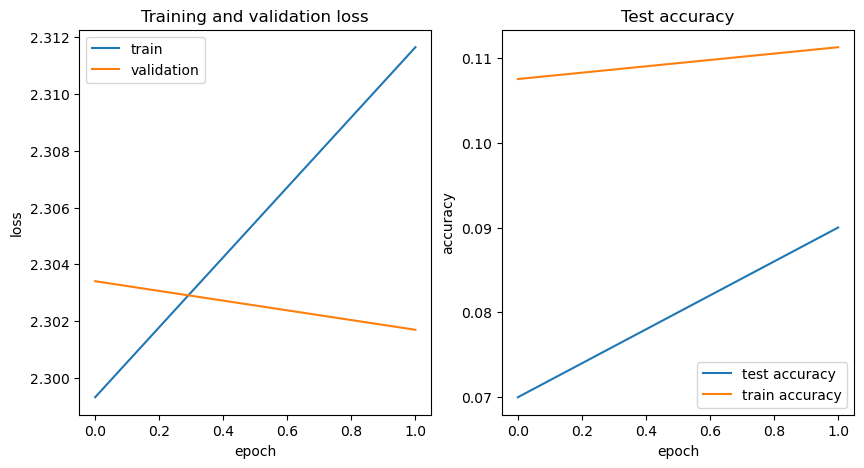

In [37]:
epochs = 2

# Histories
train_history = list()
validation_history = list()
accuracy_test_history = list()
accuracy_train_history = list()

# Training loop
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    validation_loss = test_loss(test_dataloader, model, loss_fn)


    train_history.append(train_loss)
    validation_history.append(validation_loss)
    accuracy_test_history.append(test_accuracy(test_dataloader, model))
    accuracy_train_history.append(test_accuracy(train_dataloader, model))
print("Done!")

print(f"{test_accuracy(test_dataloader, model)*100:.2f}%")


# Plots
fig, axs = plt.subplots(1,2, figsize=(10, 5))

# Training and validation loss
axs[0].plot(train_history, label = 'train')
axs[0].plot(validation_history, label = 'validation')
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("loss")
axs[0].set_title("Training and validation loss")
axs[0].legend()

# Accuracy
axs[1].plot(accuracy_test_history, label = 'test accuracy')
axs[1].plot(accuracy_train_history, label = 'train accuracy')
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("accuracy")
axs[1].set_title("Test accuracy")
axs[1].legend()

# Saving the models

This code saves the full model:

In [38]:
torch.save(model, 'models\\model_weights_conv.pth')

To Load and use the model do:

In [39]:
model = torch.load('models\\model_weights_conv.pth')
#model.eval()  # Set the model to evaluation mode